[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/data_quality/data-stats.ipynb)

This notebook demonstrates extracting required statistics for normalising data

In [2]:
from tqdm import tqdm
import pandas as pd
import s3fs
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from multiprocessing.pool import ThreadPool 
import os

print(os.cpu_count())

4


# Define Statistics Function

In [3]:
def get_stats(img_arr: np.array) -> dict:
    """Return dict of image stats"""
    
    response = {}
    response.update({"min": str(np.min(img_arr))})
    response.update({"max": str(np.max(img_arr))})
    response.update({"sum": str(np.sum(img_arr))})
    response.update({"mean": str(np.mean(img_arr))})
    response.update({"standard_deviation": str(np.std(img_arr))})
    response.update({"1th_percentile": str(np.percentile(img_arr, 1))})
    response.update({"5th_percentile": str(np.percentile(img_arr, 5))})
    response.update({"25th_percentile": str(np.percentile(img_arr, 25))})
    response.update({"75th_percentile": str(np.percentile(img_arr, 75))})
    response.update({"95th_percentile": str(np.percentile(img_arr, 95))})
    response.update({"99th_percentile": str(np.percentile(img_arr, 99))})
    response.update({"nan_count": str(np.isnan(img_arr).sum())})
    return response

# Read Samples from S3 and Run Through Statistics Function

In [4]:
fs = s3fs.S3FileSystem()

In [17]:
%%writefile ~/.aws/credentials

[default]
aws_access_key_id = ACCESS_KEY
aws_secret_access_key = SECRET_ACCESS_KEY

Overwriting /home/studio-lab-user/.aws/credentials


In [18]:
%%writefile ~/.aws/config

[default]
region=eu-west-2

Overwriting /home/studio-lab-user/.aws/config


In [6]:
features = ['air_pressure_at_mean_sea_level',
 'air_temperature_at_2_metres',
 'air_temperature_at_2_metres_1hour_Maximum',
 'air_temperature_at_2_metres_1hour_Minimum',
 'eastward_wind_at_10_metres',
 'elevation',
 'integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation',
 'landcover',
 'ndvi',
 'northward_wind_at_10_metres',
 'precipitation_amount_1hour_Accumulation',
 'surface_air_pressure',
 'todays_fires',
 'todays_frp',
 'tomorrows_fires',
 'tomorrows_frp']

In [7]:
samples = fs.glob('satvu-derived-data/hackathon_data/samples/')[:-2]
sample_ids = [s.split('/')[-1] for s in samples]
len(sample_ids)

26270

In [9]:
sample_ids[:5]

['0', '1', '10', '100', '10000']

In [8]:
def get_data_for_sample(id: int) -> pd.DataFrame:
    try:
        feature_list = []
        for feature in features:
            url = f's3://satvu-derived-data/hackathon_data/samples/{id}/{feature}.npy'
            data = np.load(fs.open(url))
            img_dict = get_stats(data)
            img_dict['sample_id'] = id
            img_dict['feature'] = feature
            img_dict['url'] = url
            feature_list.append(pd.DataFrame(img_dict, index = [0]))
        return pd.concat(feature_list, axis=0, ignore_index=True)
    except Exception as e:
        print(f'Error processing sample {id}: {e}')
        return None

In [ ]:
%%time
    
with ThreadPool(os.cpu_count()) as pool:
      results = list(tqdm(pool.imap(get_data_for_sample, sample_ids), total=len(sample_ids)))
    
len(results)

Save statistics to csv file

In [ ]:
df = pd.concat(results, axis=0)
df.to_csv('data_stats.csv', index=False)
df.shape

In [31]:
stats = pd.read_csv('data_stats.csv')

# Combine Stats for Whole Dataset

In [11]:
from scipy.stats import skew, kurtosis
def handler(img_arr):
    """Accepts Lambda event and context object."""
    
    response = {}
    response.update({"min": str(np.min(img_arr))})
    response.update({"max": str(np.max(img_arr))})
    response.update({"mean": str(np.mean(img_arr))})
    response.update({"standard_deviation": str(np.std(img_arr))})
    response.update({"nan_count": str(np.isnan(img_arr).sum())})
    return response

In [25]:
for_table = {}
for i in features:
    mins = np.min(stats[stats['feature']=='%s' %i])[0]
    maxs = np.max(stats[stats['feature']=='%s' %i])[1]
    sums = np.sum(stats[stats['feature']=='%s' %i])[2]
    mean = np.mean(stats[stats['feature']=='%s' %i])[3]
    nan = np.sum(stats[stats['feature']=='%s' %i])[4]
    for_table[i] = [mins, maxs, sums,mean, nan]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [26]:
for_table_pd = pd.DataFrame(for_table).T

In [27]:
for_table_pd.columns = ['minimum', 'maximum', 'sum', 'mean', 'nan count']

In [29]:
for_table_pd

,minimum,maximum,sum,mean,nan count
air_pressure_at_mean_sea_level,98291.072689,1.055518e+05,1.086883e+13,101113.533971,3.995783e+05
air_temperature_at_2_metres,233.454304,3.084176e+02,3.075701e+10,285.993158,8.188393e+03
air_temperature_at_2_metres_1hour_Maximum,232.281783,3.084375e+02,3.084825e+10,286.907125,7.987091e+03
air_temperature_at_2_metres_1hour_Minimum,231.460242,3.076250e+02,3.081405e+10,286.447142,8.045231e+03
eastward_wind_at_10_metres,-11.538805,1.125294e+01,8.441819e+06,0.078487,4.382893e+03
elevation,-41.752130,4.355983e+03,9.471180e+10,880.306023,4.356310e+06
integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation,-13.960936,1.747005e+06,7.280323e+12,67677.819355,5.665472e+07
landcover,10.000000,1.000000e+02,2.758116e+09,25.635517,5.395683e+05
ndvi,-1.000000,1.000000e+00,4.794658e+07,0.450878,5.142470e+03
northward_wind_at_10_metres,-10.710242,9.768605e+00,-7.221049e+07,-0.671243,4.463459e+03


In [28]:
for_table_pd.to_csv('stats_table.csv')

# Plot Histograms for Important Features

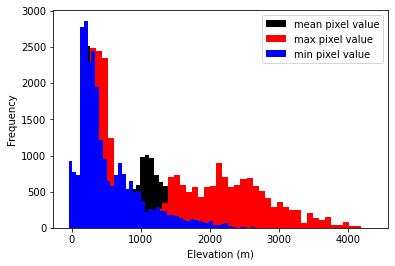

In [18]:
import matplotlib.pyplot as plt
elevation_stats= stats[stats['feature'] == 'elevation']
plt.hist(elevation_stats['mean'], bins = 50, color = 'k', label = 'mean pixel value')
plt.hist(elevation_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
plt.hist(elevation_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('Elevation (m)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/elevation.png', dpi=250)

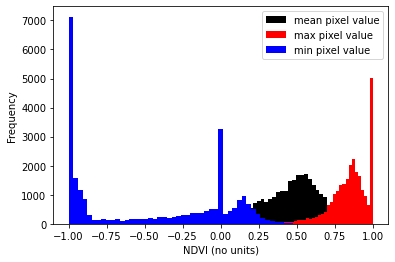

In [19]:
ndvi_stats = stats[stats['feature'] == 'ndvi']
plt.hist(ndvi_stats['mean'], bins = 50, color = 'k', label = 'mean pixel value')
plt.hist(ndvi_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
plt.hist(ndvi_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('NDVI (no units)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/ndvi.png', dpi=250)

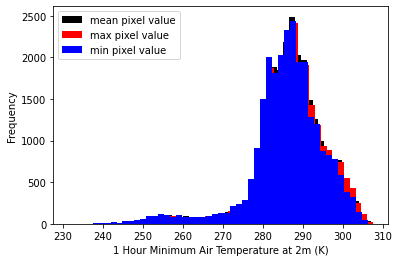

In [20]:
temp_stats = stats[stats['feature'] == 'air_temperature_at_2_metres_1hour_Minimum']
plt.hist(temp_stats['mean'], bins = 50, color = 'k', label = 'mean pixel value')
plt.hist(temp_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
plt.hist(temp_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('1 Hour Minimum Air Temperature at 2m (K)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/min_temp_2.png', dpi=250)

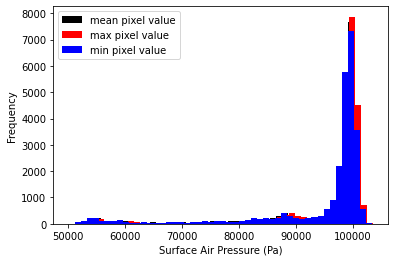

In [21]:
pressure_stats = stats[stats['feature'] == 'surface_air_pressure']
plt.hist(pressure_stats['mean'], bins = 50, color = 'k', label = 'mean pixel value')
plt.hist(pressure_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
plt.hist(pressure_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('Surface Air Pressure (Pa)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/surface_pressure.png', dpi=250)

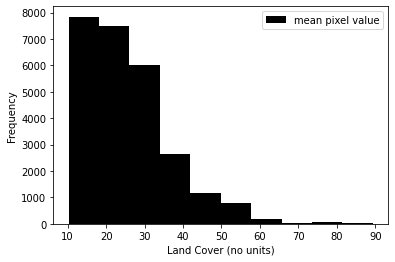

In [22]:
land_stats = stats[stats['feature'] == 'landcover']
plt.hist(land_stats['mean'], bins = 10, color = 'k', label = 'mean pixel value')
#plt.hist(land_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
#plt.hist(land_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('Land Cover (no units)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/landcover.png', dpi=250)

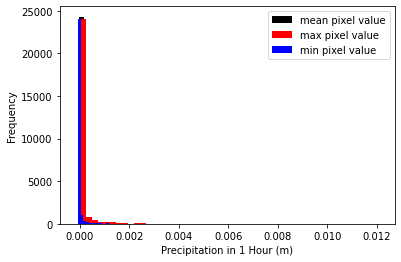

In [23]:
precip_stats = stats[stats['feature'] == 'precipitation_amount_1hour_Accumulation']
plt.hist(precip_stats['mean'], bins = 50, color = 'k', label = 'mean pixel value')
plt.hist(precip_stats['max'], bins = 50, color = 'r', label = 'max pixel value')
plt.hist(precip_stats['min'], bins = 50, color = 'b', label = 'min pixel value')
plt.xlabel('Precipitation in 1 Hour (m)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('figures/precip.png', dpi=250)

# Create Pandas Dataframe for Fire Masks

In [32]:
fires_today = stats[stats['feature'] == 'todays_fires'].filter(['sample_id', 'sum'])

In [33]:
fires_tomorrow = stats[stats['feature'] == 'tomorrows_fires'].filter(['sample_id', 'sum'])

In [34]:
fires = pd.DataFrame()

In [35]:
fires['sample_id'] = fires_today['sample_id'].values

In [36]:
fires['today_pixels'] = fires_today['sum'].values

In [37]:
fires['tomorrow_pixels'] = fires_tomorrow['sum'].values

In [38]:
fires

,sample_id,today_pixels,tomorrow_pixels
0,0,25.0,0.0
1,1,19.0,2.0
2,10,23.0,0.0
3,100,39.0,0.0
4,10000,66.0,83.0
...,...,...,...
26262,9995,184.0,96.0
26263,9996,25.0,10.0
26264,9997,26.0,0.0
26265,9998,29.0,15.0


## Filter No/Smaller Fires from Dataset

In [39]:
filtered_fires = fires[(fires['today_pixels'] >= 5) & (fires['tomorrow_pixels'] >= 5)]

In [40]:
filtered_fires

,sample_id,today_pixels,tomorrow_pixels
4,10000,66.0,83.0
8,10004,119.0,301.0
9,10005,178.0,195.0
11,10007,96.0,82.0
12,10008,282.0,63.0
...,...,...,...
26261,9994,172.0,95.0
26262,9995,184.0,96.0
26263,9996,25.0,10.0
26265,9998,29.0,15.0


Save result to csv

In [160]:
filtered_fires['sample_id'].to_csv('samples_large_fires.csv', index=False)

## Filter Samples Where the Fire Grows

In [42]:
fires[(fires['tomorrow_pixels'] >= fires['today_pixels']) ]

,sample_id,today_pixels,tomorrow_pixels
4,10000,66.0,83.0
8,10004,119.0,301.0
9,10005,178.0,195.0
14,10010,264.0,345.0
34,10030,30.0,82.0
...,...,...,...
26247,9981,52.0,78.0
26249,9983,30.0,66.0
26252,9986,28.0,30.0
26253,9987,18.0,66.0


In [43]:
8620/21661

0.3979502331378976